In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

file_location = '/kaggle/input/bot-iot-pre-processed/final.csv'

dataset = pd.read_csv(file_location, low_memory=False)

dataset.head()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,subcategory,category
0,1873521,1.528096e+09,e,1,tcp,1,192.168.100.149,55866,192.168.100.3,80,...,11.153500,100,100,10.398500,11.153500,213,213,1,TCP,DDoS
1,2411088,1.528096e+09,e s,2,tcp,1,192.168.100.148,45045,192.168.100.3,80,...,0.417619,100,97,0.419152,0.417619,400,388,1,TCP,DDoS
2,3306904,1.528099e+09,e,1,udp,3,192.168.100.148,1731,192.168.100.3,80,...,0.630458,100,26,0.797278,0.630458,804,286,1,UDP,DDoS
3,3086188,1.528099e+09,e,1,udp,3,192.168.100.149,46599,192.168.100.3,80,...,0.575598,100,100,0.575598,0.575598,700,700,1,UDP,DDoS
4,1805564,1.528096e+09,e,1,tcp,1,192.168.100.148,43105,192.168.100.3,80,...,0.000000,100,72,0.000000,0.000000,100,72,1,TCP,DDoS


In [2]:
# List of chosen features
features = [
    'state_number', 'max', 'mean', 'stddev',
    'min', 'seq', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'TnP_PerProto','dur'
]
# Dropped daddr, state, dport

sampled_dataset = dataset[features + ['category', 'subcategory']]
sampled_dataset.sample(5)

,state_number,max,mean,stddev,min,seq,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,TnP_PerProto,dur,category,subcategory
34452,2,0.258123,0.258123,0.000000,0.258123,3766,2,74,142,0.258123,Normal,Normal
3176,1,0.285751,0.187247,0.132464,0.000000,186772,100,100,510,29.158985,DDoS,TCP
18756,4,4.813381,4.185222,1.222065,1.741169,19672,100,100,1700,27.269951,DoS,UDP
44670,1,0.000109,0.000109,0.000000,0.000109,12,23,48,395,0.000109,Theft,Keylogging
23551,5,0.000000,0.000000,0.000000,0.000000,33657,10,28,28,0.000000,Reconnaissance,Service_Scan


In [3]:
# split the data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(sampled_dataset, test_size=0.2, random_state=42, shuffle=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# scale the features using min max
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols = sampled_dataset.columns[:-2] 

# sampled_dataset[cols] = scaler.fit_transform(sampled_dataset[cols])
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])


# export train test as nd_array
train_X = train.values[:,0:-2].astype(float)
train_Y = train.values[:,-2]
train_Z = train.values[:,-1]

test_X = test.values[:,0:-2].astype(float)
test_Y = test.values[:,-2]
test_Z = test.values[:,-1]

In [5]:
# encode class values as integers
from sklearn.preprocessing import LabelEncoder 
# from keras.utils import np_utils

encoder_y = LabelEncoder()
encoder_y.fit(train_Y)
encoded_train_Y = encoder_y.transform(train_Y)
encoded_test_Y = encoder_y.transform(test_Y)

encoder_z = LabelEncoder()
encoder_z.fit(train_Z)
encoded_train_Z = encoder_z.transform(train_Z)
encoded_test_Z = encoder_z.transform(test_Z)

print(encoded_train_Y)
print(encoded_train_Z)

[2 2 4 ... 2 0 1]
[3 3 2 ... 3 7 7]


In [6]:
print(len(sampled_dataset['category'].unique()))
print(len(sampled_dataset['subcategory'].unique()))

5
8


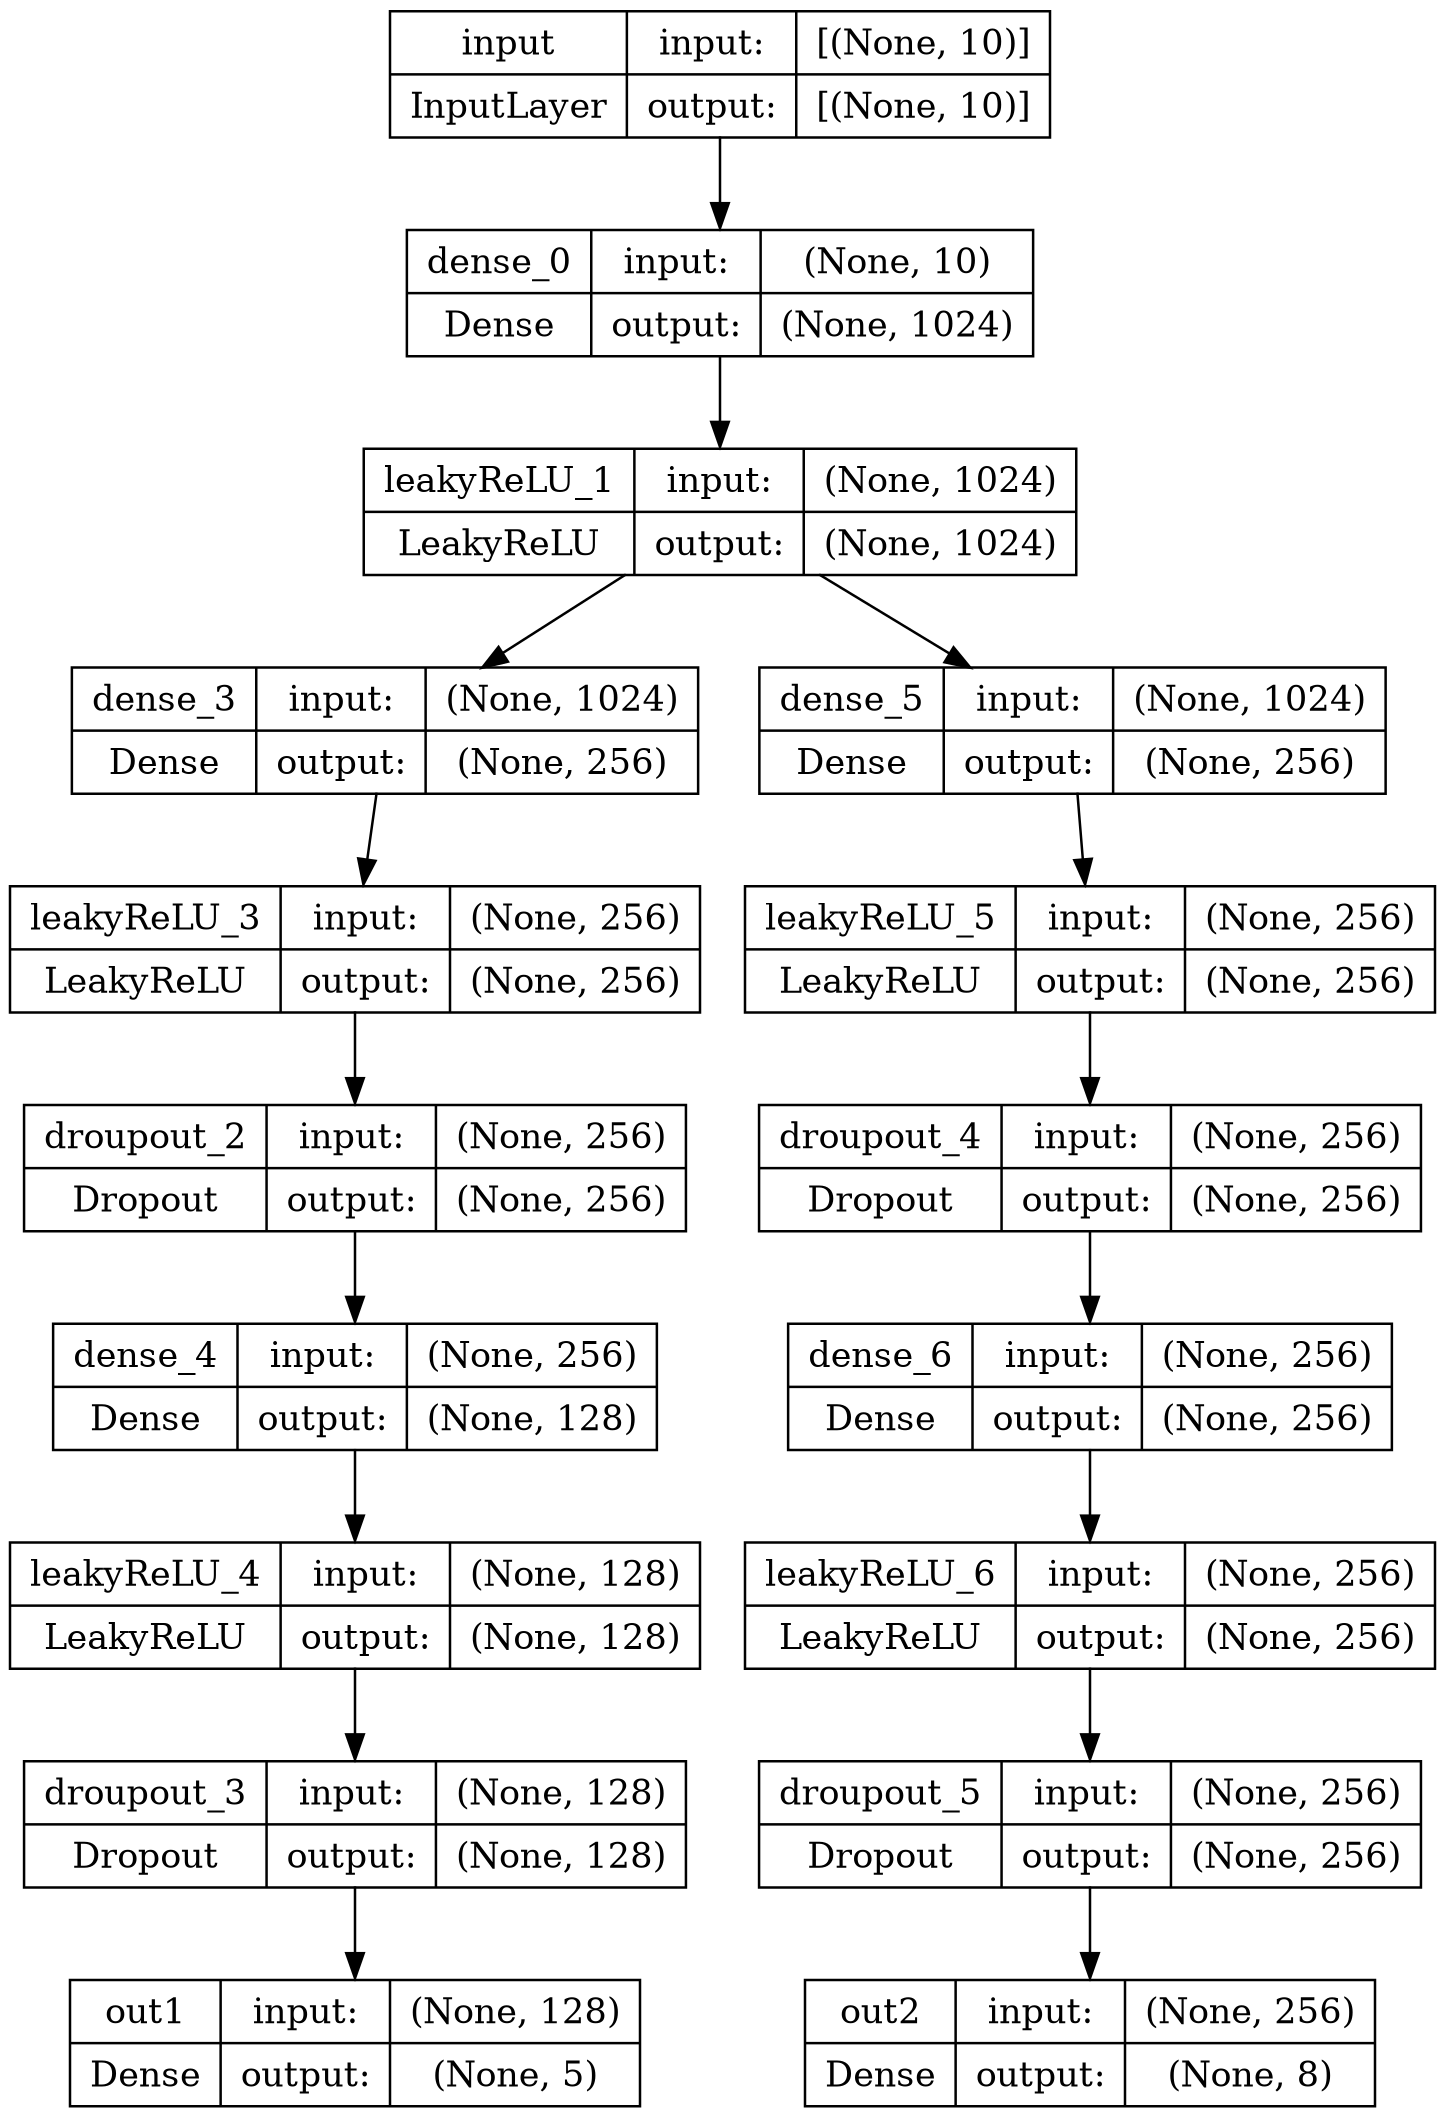

In [7]:
import tensorflow as tf
from keras.layers import Dense, LeakyReLU, Dropout, Activation, Input

#Shared Layer 
input_ = Input(shape=(10, ), name = 'input')

dense_0 = Dense(1024, name='dense_0')(input_)
leakyReLU_1 = LeakyReLU(alpha=0.01, name='leakyReLU_1')(dense_0)
# droupout_1 = Dropout(0.01, name='droupout_1')(leakyReLU_1)  # Test here


#Task 1
dense_3 = Dense(256, name='dense_3')(leakyReLU_1)
leakyReLU_3 = LeakyReLU(alpha=0.01, name='leakyReLU_3')(dense_3)
droupout_2 = Dropout(0.01, name='droupout_2')(leakyReLU_3)

dense_4 = Dense(128, name='dense_4')(droupout_2)
leakyReLU_4 = LeakyReLU(alpha=0.01, name='leakyReLU_4')(dense_4)
droupout_3 = Dropout(0.01, name='droupout_3')(leakyReLU_4)

out1 = Dense(5, activation='softmax', name='out1')(droupout_3)

#Task 2
dense_5 = Dense(256, name='dense_5')(leakyReLU_1)
leakyReLU_5 = LeakyReLU(alpha=0.01, name='leakyReLU_5')(dense_5)
droupout_4 = Dropout(0.01, name='droupout_4')(leakyReLU_5)

dense_6 = Dense(256, name='dense_6')(droupout_4)
leakyReLU_6 = LeakyReLU(alpha=0.01, name='leakyReLU_6')(dense_6)
droupout_5 = Dropout(0.01, name='droupout_5')(leakyReLU_6)

out2 = Dense(8, activation='softmax', name='out2')(droupout_5)

#Create model
model = tf.keras.models.Model(input_, [out1, out2])
#Compile model
model.compile(
              # since we have two output layer, we can define two loss function  
              loss = {
                  'out1' : 'sparse_categorical_crossentropy',
                  'out2' : 'sparse_categorical_crossentropy'
              }, 
              optimizer = 'adam',
              metrics = ['accuracy']
)

#To view the model architecture
#model.summary()
# tf.keras.utils.plot_model(model)

# Plot the model with adjusted layout
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=180)  # Adjust dpi as needed

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 10)]                 0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 1024)                 11264     ['input[0][0]']               
                                                                                                  
 leakyReLU_1 (LeakyReLU)     (None, 1024)                 0         ['dense_0[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 256)                  262400    ['leakyReLU_1[0][0]']         
                                                                                              

In [9]:
# fit the model
history = model.fit(train_X, [encoded_train_Y, encoded_train_Z], epochs=50, batch_size=50, validation_split=0.2)

Epoch 1/50
640/640 [==============================] - 10s 5ms/step - loss: 0.5384 - out1_loss: 0.2681 - out2_loss: 0.2703 - out1_accuracy: 0.8917 - out2_accuracy: 0.9030 - val_loss: 0.3238 - val_out1_loss: 0.1741 - val_out2_loss: 0.1497 - val_out1_accuracy: 0.9320 - val_out2_accuracy: 0.9452
Epoch 2/50
640/640 [==============================] - 3s 4ms/step - loss: 0.2812 - out1_loss: 0.1428 - out2_loss: 0.1384 - out1_accuracy: 0.9453 - out2_accuracy: 0.9467 - val_loss: 0.2198 - val_out1_loss: 0.1014 - val_out2_loss: 0.1184 - val_out1_accuracy: 0.9661 - val_out2_accuracy: 0.9516
Epoch 3/50
640/640 [==============================] - 3s 4ms/step - loss: 0.2333 - out1_loss: 0.1114 - out2_loss: 0.1219 - out1_accuracy: 0.9605 - out2_accuracy: 0.9528 - val_loss: 0.1985 - val_out1_loss: 0.0883 - val_out2_loss: 0.1102 - val_out1_accuracy: 0.9707 - val_out2_accuracy: 0.9550
Epoch 4/50
640/640 [==============================] - 3s 4ms/step - loss: 0.1864 - out1_loss: 0.0810 - out2_loss: 0.1055 - 

In [10]:
# Test performance
_, _, _, task1, task2 = model.evaluate(test_X, [encoded_test_Y, encoded_test_Z])
print("\nTask-1 Accuracy: %.2f%%, Tas-2 Accuracy: %.2f%%" % (task1*100, task2*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0860 - out1_loss: 0.0228 - out2_loss: 0.0632 - out1_accuracy: 0.9962 - out2_accuracy: 0.9717

Task-1 Accuracy: 99.62%, Tas-2 Accuracy: 97.17%


In [11]:
# Performance Measures 

predictions_y,  predictions_z = model.predict(test_X)
predicted_classes_y = np.argmax(predictions_y, axis=-1)
predicted_classes_z = np.argmax(predictions_z, axis=-1)

313/313 [==============================] - 1s 2ms/step


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have true labels named 'y_true'
accuracy_y = accuracy_score(encoded_test_Y, predicted_classes_y)
precision_y = precision_score(encoded_test_Y, predicted_classes_y, average='weighted')
recall_y = recall_score(encoded_test_Y, predicted_classes_y, average='weighted')
f1_y = f1_score(encoded_test_Y, predicted_classes_y, average='weighted')

accuracy_z = accuracy_score(encoded_test_Z, predicted_classes_z)
precision_z = precision_score(encoded_test_Z, predicted_classes_z, average='weighted')
recall_z = recall_score(encoded_test_Z, predicted_classes_z, average='weighted')
f1_z = f1_score(encoded_test_Z, predicted_classes_z, average='weighted')

performance_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Category': [accuracy_y, precision_y, recall_y, f1_y],
    'Sub-Category': [accuracy_z, precision_z, recall_z, f1_z]
})

print(performance_table)


      Metric  Category  Sub-Category
0   Accuracy  0.996200      0.971700
1  Precision  0.996200      0.970515
2     Recall  0.996200      0.971700
3   F1 Score  0.996199      0.967457


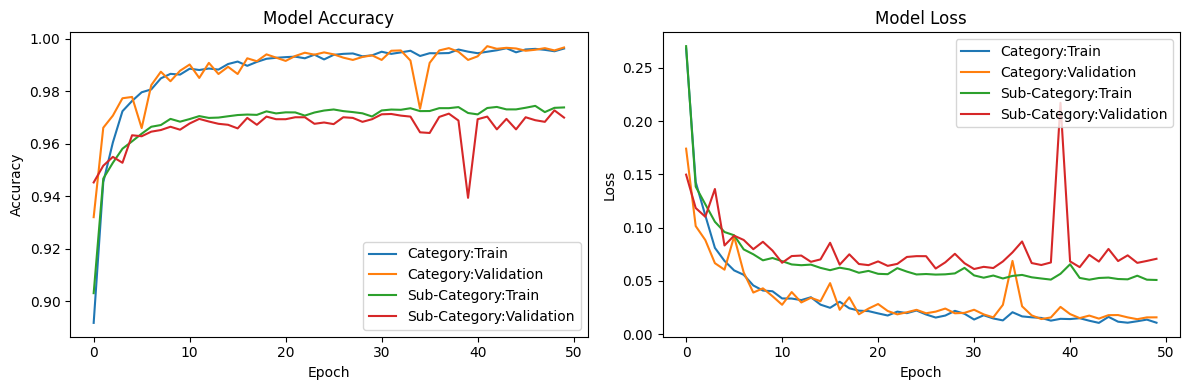

In [13]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['out1_accuracy'])
plt.plot(history.history['val_out1_accuracy'])
plt.plot(history.history['out2_accuracy'])
plt.plot(history.history['val_out2_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Category:Train', 'Category:Validation','Sub-Category:Train', 'Sub-Category:Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['out1_loss'])
plt.plot(history.history['val_out1_loss'])
plt.plot(history.history['out2_loss'])
plt.plot(history.history['val_out2_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Category:Train', 'Category:Validation','Sub-Category:Train', 'Sub-Category:Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Assuming you have a model named 'model' and test data named 'X_test'
# and true labels 'y_true' for the test set

# Convert labels to one-hot encoding
y_num_classes = len(np.unique(encoded_test_Y))
y_true_bin = label_binarize(encoded_test_Y, classes=np.arange(y_num_classes))
y_score = label_binarize(predicted_classes_y, classes=np.arange(y_num_classes))

z_num_classes = len(np.unique(encoded_test_Z))
z_true_bin = label_binarize(encoded_test_Z, classes=np.arange(z_num_classes))
z_score = label_binarize(predicted_classes_z, classes=np.arange(z_num_classes))

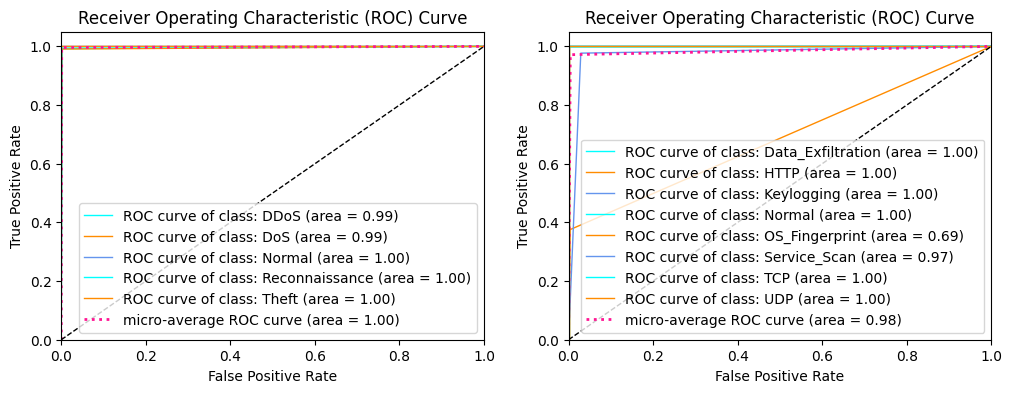

In [17]:
# Compute ROC curve and ROC area for each class
# Plot ROC curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(y_num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class: {0} (area = {1:0.2f})'
             ''.format(encoder_y.classes_[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(z_num_classes):
    fpr[i], tpr[i], _ = roc_curve(z_true_bin[:, i], z_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(z_true_bin.ravel(), z_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(z_num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class: {0} (area = {1:0.2f})'
             ''.format(encoder_z.classes_[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()